### Client: Klaveness Digital

##### Introduction

In this notebook Klaveness Digital provided us with S-AIS data in the period of 2019-2020. The dataset contains 1.4 million S-AIS messages. 

##### Objective

We have decided to tackle problem a) where the objective is to analyze the sailing route to a selected port and predict sailing time from a point to the selected port.

Selected port: Port Singapore. (Why?)

###### Assumptions
1. A ship/vessel has reached its destination when it first anchors inside a defined box around port Singapore. 
2. Defined box around Singapore was drawn on geojson.io where we ended up with the coordinates: lat_low , lat_high, lon_low , lon_high.
3. Ships can visit the same port multiple times, but only once per month. 



##### Read the data

1. read the datafile "A.csv" into a dataframe. 
2. Describe the dataframe


##### Data cleaning

Before we analyze sailing route and make a prediction model we have to clean the data. 

Here are the steps. 
1. We want to find the ships that have reached the destination. Create a new dataframe, anchored, from the original which containts the satisfied conditions: nav == 1 (anchored), and the position is inside the box. We store the indexes in the anchored dataframe in a list, idx, and use the list to locate all the rows in the original dataframe. The new dataframe, port, contains all AIS messages of anchored positions in port Singapore. 


2. (2.1) DF Port contains multiple AIS from the same vessel, where we are only interested in finding the first message from each ship anchored in Singapore. Since we assume that ships only can visit the port once per month we create a new feature 'date' which stores the year and month of each anchored AIS messages. (2.2) Next, we want to store the first AIS message for each ship conditioned on month in a list called ix.


3. The dataframe port has a column named index which contains the indexes in the original dataframe (df). These index values are the AIS messages of first anchored for each ship. We are now interested in finding the incoming ship's routes to Singapore. We have done this in the three following steps: 

    3.1 Trim the dataframe to only include the first AIS messages of anchored positions. We created a new column 'dest' with binary values (1 if AIS message is anchored in singapore, 0 otherwise). Used the ix list from 2.2
    
    3.2 Next we want to remove all ships that does not have Singapore as its destination. unique_imo contains the list of all ships that anchors in Singapore. The original dataframe (df) is merged with unique_imo which only includes ships that has anchored in Singapore. 
    
    3.3 We now want to trim the dataset even further by only including the AIS messages between the previous port visited and the destination. This is done in the following steps:
    
       1. Create a new list, moored, that contains the previous ports' position for all ships that has anchored in Singapore.
       
       2. Create a new column in the original dataframe (df) called prev_dest (binary). Drop all rows in df where previous port positions does not have Singapore as the destionation. 
       
       3. Next we only want to include the AIS messages between the last port visited and Singapore destination in our dataset. The list ll contains all the indexes in df where AIS messages is between previous port and destination. 
       

4. Now we will work with a new dataframe called new_df which contains AIS-messages from all previous ports visited to the destination port. (used the list ll on the original df). 


#### SOUTH AMERICA





#### Imports

In [2]:
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon


from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score


import random

#### Singapore coordinates (destination port)

In [2]:
# Singapore
lat_low = 1.19
lat_high = 1.341
lon_low = 103.6
lon_high = 104.05

#### Read the data

In [5]:
df = pd.read_csv("A.csv")
df[10:13]

,imo,time,lat,lon,nav,status
10,5103974,2019-05-17T12:49:14Z,44.621317,-75.619650,0,moving
11,5103974,2019-05-17T23:15:15Z,45.172650,-74.334233,0,moving
12,5103974,2019-05-18T07:59:02Z,45.482333,-73.512533,0,moving


In [4]:
print("Number of rows: %d" %len(df.imo))
print("Number of unique ships: %d" %len(df.imo.unique()))
print("Features: %s" %(df.columns))

Number of rows: 1048575
Number of unique ships: 1339
Features: Index(['imo', 'time', 'lat', 'lon', 'nav', 'status'], dtype='object')


# Data cleaning

#### 1


In [5]:
anchored = df[(df.nav == 1) & (df.status == ' anchorage')].where((lat_low <= df.lat)&(df.lat <= lat_high) & (lon_low <= df.lon) & (df.lon <= lon_high)).dropna()
idx = np.array(anchored.index)

port = df.loc[idx,:].reset_index()

port.head()

,index,imo,time,lat,lon,nav,status
0,16462,8800315,2020-02-01T23:57:46Z,1.285895,103.986920,1,anchorage
1,16463,8800315,2020-02-02T07:57:47Z,1.284885,103.986773,1,anchorage
2,25929,9036806,2019-12-17T23:59:51Z,1.283538,103.950895,1,anchorage
3,27748,9050395,2019-05-29T23:57:28Z,1.277775,103.970787,1,anchorage
4,27787,9050395,2019-08-08T15:59:39Z,1.279397,103.953867,1,anchorage


In [6]:
len(port.imo.unique())

777

#### 2.1


In [7]:
port['date'] = 0
for i in range(0, len(port.time)):
    
    t = datetime.datetime.strptime(port.time[i], " %Y-%m-%dT%H:%M:%SZ")
    
    port.date[i] = t.strftime("%Y-%m")

port.sort_values(by=['imo', 'time'], inplace=True)


/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### 2.2

In [8]:
ix = [] #Store all indexes in a list

# For each imo, add the first index[0] to the list, and check if there are other unique anchor dates
for im in port.imo.unique():
    date = [] # contains unique date for each imo
    p = port[port.imo == im]
    ix.append(p.index[0])
    date.append(p.date[p.index[0]])
    
    s = p.index[0]+1
    e = p.index[-1]
    
    
    for i in range(s,e):
        if (p.date[i] not in date): 
            ix.append(i)
            date.append(p.date[i])
             
port.loc[ix,:]

,index,imo,time,lat,lon,nav,status,date
0,16462,8800315,2020-02-01T23:57:46Z,1.285895,103.986920,1,anchorage,2020-02
2,25929,9036806,2019-12-17T23:59:51Z,1.283538,103.950895,1,anchorage,2019-12
3,27748,9050395,2019-05-29T23:57:28Z,1.277775,103.970787,1,anchorage,2019-05
4,27787,9050395,2019-08-08T15:59:39Z,1.279397,103.953867,1,anchorage,2019-08
7,36499,9079145,2019-09-16T15:55:52Z,1.283098,103.959098,1,anchorage,2019-09
...,...,...,...,...,...,...,...,...
4283,1047127,9548201,2019-05-28T15:58:33Z,1.284655,103.984557,1,anchorage,2019-05
4284,1047871,9548213,2019-05-09T15:58:59Z,1.282153,103.974268,1,anchorage,2019-05
4287,1048019,9548213,2019-07-18T15:58:05Z,1.277038,103.936347,1,anchorage,2019-07
4290,1048126,9548213,2019-09-08T07:57:05Z,1.279440,103.948883,1,anchorage,2019-09


#### 3 

#### 3.1

In [9]:
df['dest'] = 0
df.loc[port.loc[ix, 'index'], 'dest'] = 1



In [10]:
dropp = df.where((df.dest != 1) & (df.nav == 1) & (df.status == ' anchorage')).dropna().index
df.drop(dropp, axis=0, inplace=True)

#### 3.2

In [11]:
unique_imo = pd.DataFrame(port.loc[ix, 'imo'].unique(), columns=['imo'])

df = df.merge(unique_imo, left_on='imo', right_on='imo')


In [12]:
df

,imo,time,lat,lon,nav,status,dest
0,8800315,2019-03-26T15:57:13Z,68.988153,33.054073,5,moored,0
1,8800315,2019-03-26T23:57:17Z,68.988153,33.053873,5,moored,0
2,8800315,2019-03-27T07:57:14Z,68.988180,33.053983,5,moored,0
3,8800315,2019-03-27T15:57:14Z,68.988160,33.053910,5,moored,0
4,8800315,2019-03-27T23:59:24Z,68.988153,33.054070,5,moored,0
...,...,...,...,...,...,...,...
511692,9548213,2020-02-14T20:29:38Z,-26.574445,-39.257030,0,moving,0
511693,9548213,2020-02-15T07:58:36Z,-25.729760,-41.660620,0,moving,0
511694,9548213,2020-02-15T15:10:46Z,-25.208818,-43.151352,0,moving,0
511695,9548213,2020-02-15T23:35:17Z,-24.562293,-44.977613,0,moving,0


#### 3.3.1

In [13]:
test = df.where((df.nav == 5) & (df.status == ' moored') | (df.dest == 1)).dropna() # Only include moored or destination positions. 

moored = [] # list contains the index of the last moored position

for im in test.imo.unique():
    
    t = test[test.imo == im]
    last_moored = -1 #t.index[0]
    
    for i in t.index:

        if (t.nav[i] == 5.0 and t.status[i] == ' moored'): 
            last_moored = i
        
        if (t.dest[i] == 1 and last_moored != -1):
            moored.append(last_moored)     
            last_moored = -1
            
        
            
           
            
        

#### 3.3.2

In [14]:
df['prev_dest'] = 0

df.loc[moored, 'prev_dest'] = 1

drop_ix = df.where((df.nav == 5) & (df.status == ' moored') & (df.prev_dest != 1)).dropna().index

print(drop_ix)

df.drop(drop_ix, axis=0, inplace=True)

Int64Index([     0,      1,      2,      3,      4,      5,     36,     37,
                38,     39,
            ...
            511538, 511539, 511540, 511592, 511593, 511594, 511595, 511596,
            511597, 511598],
           dtype='int64', length=92618)


In [15]:
# drop indexes

d1 = df.where( (df.nav == 0) & (df.status != ' moving') | (df.nav != 0) & (df.status == ' moving')).dropna().index
df.drop(d1, axis=0, inplace=True)

d2 = df.where( (df.nav == 5) & (df.status != ' moored') | (df.nav != 5) & (df.status == ' moored')).dropna().index
df.drop(d2, axis=0, inplace=True)

d3 = df.where( (df.nav == 1) & (df.status != ' anchorage') | (df.nav != 1) & (df.status == ' anchorage')).dropna().index
df.drop(d3, axis=0, inplace=True)

df

,imo,time,lat,lon,nav,status,dest,prev_dest
6,8800315,2019-03-28T15:49:43Z,69.908927,33.510083,0,moving,0,0
7,8800315,2019-03-28T23:59:13Z,70.521813,32.487130,0,moving,0,0
8,8800315,2019-03-29T07:59:42Z,70.479247,32.657653,0,moving,0,0
9,8800315,2019-03-29T15:59:24Z,70.699333,32.081490,0,moving,0,0
10,8800315,2019-03-29T23:58:32Z,71.359833,29.647953,0,moving,0,0
...,...,...,...,...,...,...,...,...
511692,9548213,2020-02-14T20:29:38Z,-26.574445,-39.257030,0,moving,0,0
511693,9548213,2020-02-15T07:58:36Z,-25.729760,-41.660620,0,moving,0,0
511694,9548213,2020-02-15T15:10:46Z,-25.208818,-43.151352,0,moving,0,0
511695,9548213,2020-02-15T23:35:17Z,-24.562293,-44.977613,0,moving,0,0


In [16]:
df.reset_index(drop=True, inplace=True)

#### 3.3.3

In [17]:
ll = []

for im in df.imo.unique():
    
    t = df[df.imo == im]
     
    start = t[t.prev_dest == 1].index
    end = t[t.dest == 1].index
    
    if (len(start) == len(end)):
        
    
        for i in range(0,len(start)):

            for j in range(start[i], end[i]+1): # +1 to include the dest
                ll.append(j)

len(ll)

58679

#### 4

In [18]:
new_df = df.loc[ll,:]
new_df.reset_index(drop=True, inplace=True)
new_df

,imo,time,lat,lon,nav,status,dest,prev_dest
0,8800315,2019-12-03T07:58:05Z,68.986860,33.057983,5,moored,0,1
1,8800315,2019-12-03T15:47:39Z,69.872647,33.572233,0,moving,0,0
2,8800315,2019-12-03T23:58:30Z,71.030773,30.963733,0,moving,0,0
3,8800315,2019-12-04T07:59:49Z,71.675973,26.817832,0,moving,0,0
4,8800315,2019-12-04T15:59:40Z,71.578140,22.849198,0,moving,0,0
...,...,...,...,...,...,...,...,...
58674,9548213,2019-12-09T12:01:17Z,2.780885,90.655395,0,moving,0,0
58675,9548213,2019-12-09T18:02:07Z,3.434393,91.527842,0,moving,0,0
58676,9548213,2019-12-12T14:30:07Z,2.128923,101.987722,0,moving,0,0
58677,9548213,2019-12-12T23:57:56Z,1.237242,103.353607,0,moving,0,0


In [19]:
df_add = new_df
df_add['marker'] = 0.1
df_add['color'] = 'b'

temp = {"lat": [1.2],
        'lon': [113],
        'marker': [5],
        'color': ['r']}
temp = pd.DataFrame(temp, columns=['lat', 'lon','marker', 'color'])

pd.concat([df_add, temp])



,imo,time,lat,lon,nav,status,dest,prev_dest,marker,color
0,8800315.0,2019-12-03T07:58:05Z,68.986860,33.057983,5.0,moored,0.0,1.0,0.1,b
1,8800315.0,2019-12-03T15:47:39Z,69.872647,33.572233,0.0,moving,0.0,0.0,0.1,b
2,8800315.0,2019-12-03T23:58:30Z,71.030773,30.963733,0.0,moving,0.0,0.0,0.1,b
3,8800315.0,2019-12-04T07:59:49Z,71.675973,26.817832,0.0,moving,0.0,0.0,0.1,b
4,8800315.0,2019-12-04T15:59:40Z,71.578140,22.849198,0.0,moving,0.0,0.0,0.1,b
...,...,...,...,...,...,...,...,...,...,...
58675,9548213.0,2019-12-09T18:02:07Z,3.434393,91.527842,0.0,moving,0.0,0.0,0.1,b
58676,9548213.0,2019-12-12T14:30:07Z,2.128923,101.987722,0.0,moving,0.0,0.0,0.1,b
58677,9548213.0,2019-12-12T23:57:56Z,1.237242,103.353607,0.0,moving,0.0,0.0,0.1,b
58678,9548213.0,2019-12-13T07:58:37Z,1.276417,103.947303,1.0,anchorage,1.0,0.0,0.1,b


/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


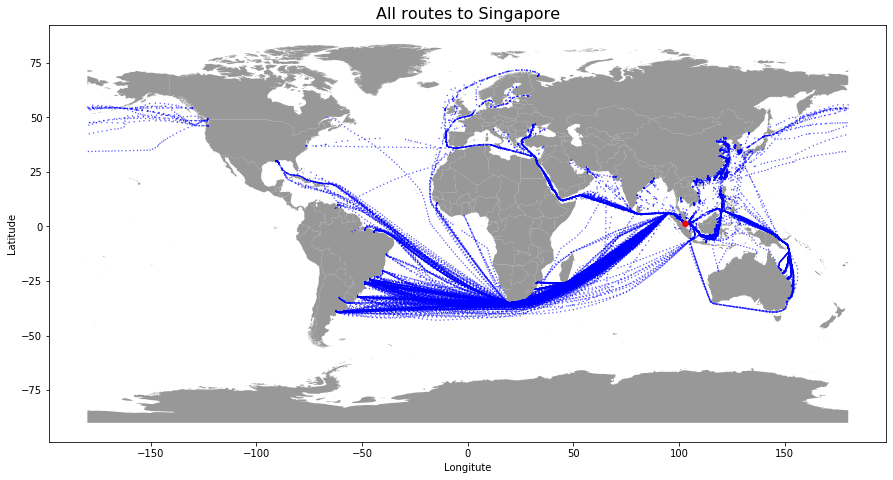

In [20]:
fig, axs = plt.subplots(figsize = (15, 15))
crs = {"init": "epsg:4326"}

df_add = new_df
df_add['marker'] = 0.1
df_add['color'] = 'b'

temp = {"lat": [1.2],
        'lon': [103],
        'marker': [30],
        'color': ['r']}
temp = pd.DataFrame(temp, columns=['lat', 'lon','marker', 'color'])

df_add = pd.concat([df_add, temp])

geometry = [Point(xy) for xy in zip(df_add.lon, df_add.lat)]


geo_df_new = gpd.GeoDataFrame(df_add, crs = crs, geometry = geometry)


world_map = gpd.read_file("World_Countries/World_Countries.shp")

plt.title("All routes to Singapore", fontdict={'fontsize': 16})
plt.xlabel("Longitute")
plt.ylabel("Latitude")

world_map.plot(ax = axs, alpha = 50, color = "grey")
geo_df_new.plot(ax=axs, markersize = df_add.marker, c = df_add.color)


plt.savefig("ALL ROUTES TO SINGAPORE.png")

# South America Part

## New dataframe

In [113]:
sl = []

LAT = -20

t = df[df.prev_dest == 1]

sa_imo = t.imo.unique() # If only include previous destinations from South America

imo = sa_imo 

for im in imo:
    
    t = df[df.imo == im]
     
    start = t[t.prev_dest == 1].index
    end = t[t.dest == 1].index
    
    for i in range(0,len(start)):
        
        if ( df.lat[start[i]] < LAT and df.lon[start[i]] < -35): ## ONLY SOUTH AMERICA !!!!! #####
            for j in range(start[i], end[i]+1):
                sl.append(j)

                

In [114]:
sma = df.loc[sl,:]
sma.reset_index(drop=True, inplace=True)
sma

,imo,time,lat,lon,nav,status,dest,prev_dest
0,9147423,2019-08-21T23:59:25Z,-25.501438,-48.505775,5,moored,0,1
1,9147423,2019-08-22T07:46:20Z,-25.628825,-48.247348,0,moving,0,0
2,9147423,2019-08-22T15:59:40Z,-26.246997,-46.655675,0,moving,0,0
3,9147423,2019-08-22T23:34:59Z,-26.777072,-45.265738,0,moving,0,0
4,9147423,2019-08-23T07:12:22Z,-27.341678,-43.755343,0,moving,0,0
...,...,...,...,...,...,...,...,...
31128,9548201,2019-05-24T18:23:30Z,1.051670,88.891480,0,moving,0,0
31129,9548201,2019-05-25T03:39:59Z,2.242463,90.284727,0,moving,0,0
31130,9548201,2019-05-25T13:59:58Z,3.603965,91.896975,0,moving,0,0
31131,9548201,2019-05-28T07:58:18Z,1.577408,102.871503,0,moving,0,0


## Feauture Engineering

### Transform time to datetime object

In [115]:
sma["ttime"] = 0

for i in range(0, len(sma.time)):
    
    t = datetime.datetime.strptime(sma.time[i], " %Y-%m-%dT%H:%M:%SZ")
    sma.ttime[i] = t


/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Date

In [116]:
sma.reset_index(drop=True, inplace=True)
sma['date'] = 0

for i in range(0, len(sma.ttime)):
        
    sma.date[i] = sma.ttime[i].strftime("%Y-%m")
    
sma.head()

/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,imo,time,lat,lon,nav,status,dest,prev_dest,ttime,date
0,9147423,2019-08-21T23:59:25Z,-25.501438,-48.505775,5,moored,0,1,2019-08-21 23:59:25,2019-08
1,9147423,2019-08-22T07:46:20Z,-25.628825,-48.247348,0,moving,0,0,2019-08-22 07:46:20,2019-08
2,9147423,2019-08-22T15:59:40Z,-26.246997,-46.655675,0,moving,0,0,2019-08-22 15:59:40,2019-08
3,9147423,2019-08-22T23:34:59Z,-26.777072,-45.265738,0,moving,0,0,2019-08-22 23:34:59,2019-08
4,9147423,2019-08-23T07:12:22Z,-27.341678,-43.755343,0,moving,0,0,2019-08-23 07:12:22,2019-08


### Arrived Singapore

In [117]:
moving = sma[sma.status == ' moving']

eps = 1

arrived_ix = []
dd = {}

for ix in moving.index:
    lat = moving.lat[ix]
    lon = moving.lon[ix]
    
    
    
    imo = sma.imo[ix]
    date = sma.date[ix]
    
    if ( (lat_low-eps < lat and lat < lat_high+eps ) and ( lon_low-eps < lon and lon < lon_high+eps )):
        if (imo not in dd.keys()):
            dd[imo] = [date]
            arrived_ix.append(ix)
        
        else:
            if (date not in dd.get(imo)):
                dd[imo].append(date)
                arrived_ix.append(ix)
            
            

sma['arrived'] = 0
sma.loc[arrived_ix, 'arrived'] = 1
len(sma.imo.unique())

268

### Calculate Time to Arrived

In [118]:
sma.reset_index(drop=True, inplace=True)
sma['tta_new'] = 0


for im in sma.imo.unique():
    
    t = sma[sma.imo == im]
    
    start = t[t.prev_dest == 1].index
    end = t[t.arrived == 1].index
    if (len(start) == len(end)):
        for i in range(0,len(start)):

            for j in range(start[i], end[i]): # include moored (+0), else (+1)

                sma.tta_new[j] = t.ttime[end[i]] - t.ttime[j]
            
sma

/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,imo,time,lat,lon,nav,status,dest,prev_dest,ttime,date,arrived,tta_new
0,9147423,2019-08-21T23:59:25Z,-25.501438,-48.505775,5,moored,0,1,2019-08-21 23:59:25,2019-08,0,0
1,9147423,2019-08-22T07:46:20Z,-25.628825,-48.247348,0,moving,0,0,2019-08-22 07:46:20,2019-08,0,0
2,9147423,2019-08-22T15:59:40Z,-26.246997,-46.655675,0,moving,0,0,2019-08-22 15:59:40,2019-08,0,0
3,9147423,2019-08-22T23:34:59Z,-26.777072,-45.265738,0,moving,0,0,2019-08-22 23:34:59,2019-08,0,0
4,9147423,2019-08-23T07:12:22Z,-27.341678,-43.755343,0,moving,0,0,2019-08-23 07:12:22,2019-08,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31128,9548201,2019-05-24T18:23:30Z,1.051670,88.891480,0,moving,0,0,2019-05-24 18:23:30,2019-05,0,"3 days, 13:34:48"
31129,9548201,2019-05-25T03:39:59Z,2.242463,90.284727,0,moving,0,0,2019-05-25 03:39:59,2019-05,0,"3 days, 4:18:19"
31130,9548201,2019-05-25T13:59:58Z,3.603965,91.896975,0,moving,0,0,2019-05-25 13:59:58,2019-05,0,"2 days, 17:58:20"
31131,9548201,2019-05-28T07:58:18Z,1.577408,102.871503,0,moving,0,0,2019-05-28 07:58:18,2019-05,1,0


### Estimated Time of Arrival

In [346]:
sma['eta'] = 0

for i in range(0, len(sma.tta_new)):
    if (sma.tta_new[i] != 0):
        sma.eta[i] = sma.tta_new[i].days*24 + sma.tta_new[i].seconds/3600 # hours
    
sma


/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,imo,time,lat,lon,nav,status,dest,prev_dest,ttime,date,arrived,tta_new,eta
0,9147423,2019-08-21T23:59:25Z,-25.501438,-48.505775,5,moored,0,1,2019-08-21 23:59:25,2019-08,0,0,0
1,9147423,2019-08-22T07:46:20Z,-25.628825,-48.247348,0,moving,0,0,2019-08-22 07:46:20,2019-08,0,0,0
2,9147423,2019-08-22T15:59:40Z,-26.246997,-46.655675,0,moving,0,0,2019-08-22 15:59:40,2019-08,0,0,0
3,9147423,2019-08-22T23:34:59Z,-26.777072,-45.265738,0,moving,0,0,2019-08-22 23:34:59,2019-08,0,0,0
4,9147423,2019-08-23T07:12:22Z,-27.341678,-43.755343,0,moving,0,0,2019-08-23 07:12:22,2019-08,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31128,9548201,2019-05-24T18:23:30Z,1.051670,88.891480,0,moving,0,0,2019-05-24 18:23:30,2019-05,0,"3 days, 13:34:48",85
31129,9548201,2019-05-25T03:39:59Z,2.242463,90.284727,0,moving,0,0,2019-05-25 03:39:59,2019-05,0,"3 days, 4:18:19",76
31130,9548201,2019-05-25T13:59:58Z,3.603965,91.896975,0,moving,0,0,2019-05-25 13:59:58,2019-05,0,"2 days, 17:58:20",65
31131,9548201,2019-05-28T07:58:18Z,1.577408,102.871503,0,moving,0,0,2019-05-28 07:58:18,2019-05,1,0,0


## CLEAN DATA

In [120]:
data = sma[sma.status == ' moving']

data = data[data.eta != 0]
data = data.loc[:, ['imo', 'lat', 'lon', 'arrived', 'eta']]
data.reset_index(drop=True, inplace=True)
data

,imo,lat,lon,arrived,eta
0,9174634,-24.415597,-45.017662,0,734
1,9174634,-24.804038,-43.226043,0,726
2,9174634,-25.115183,-41.584053,0,718
3,9174634,-25.397375,-39.937208,0,711
4,9174634,-25.726933,-38.017045,0,702
...,...,...,...,...,...
28388,9548201,-1.108133,86.370282,0,102
28389,9548201,0.694397,88.473750,0,88
28390,9548201,1.051670,88.891480,0,85
28391,9548201,2.242463,90.284727,0,76


#### DROP IMO WITH ANOMALITIES

In [121]:
drop_imos = data.loc[data.lat.sort_values(ascending=False)[:7].index, :].imo.unique()

drop_ix = []
for im in drop_imos:
    t = data[data.imo == im]
    
    for i in t.index:
        drop_ix.append(i)

data.drop(drop_ix, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

# Plot

/Users/olavnyland/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


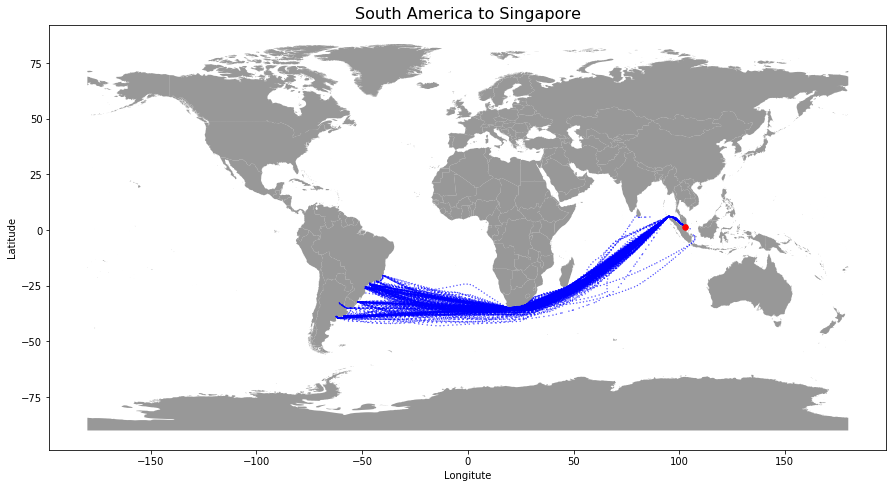

In [122]:
fig, axs = plt.subplots(figsize = (15, 15))
crs = {"init": "epsg:4326"}

df_add = data
df_add['marker'] = 0.1
df_add['color'] = 'b'

temp = {"lat": [1.2],
        'lon': [103],
        'marker': [30],
        'color': ['r']}
temp = pd.DataFrame(temp, columns=['lat', 'lon','marker', 'color'])

df_add = pd.concat([df_add, temp])

geometry = [Point(xy) for xy in zip(df_add.lon, df_add.lat)]


geo_df_new = gpd.GeoDataFrame(df_add, crs = crs, geometry = geometry)


world_map = gpd.read_file("World_Countries/World_Countries.shp")

plt.title("South America to Singapore", fontdict={'fontsize': 16})
plt.xlabel("Longitute")
plt.ylabel("Latitude")

world_map.plot(ax = axs, alpha = 50, color = "grey")
geo_df_new.plot(ax=axs, markersize = df_add.marker, c = df_add.color)


plt.savefig("SOUTH AMERICA TO SINGAPORE.png")

## Exploratory Data Analysis

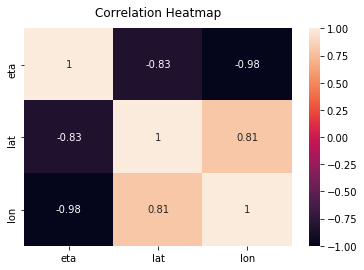

In [123]:
heatmap = sns.heatmap(data.loc[:, ['eta', 'lat', 'lon']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("correlation heatmap.png")

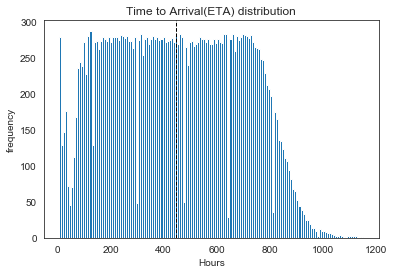

In [419]:
plt.hist(data.eta, bins=150)

plt.axvline(data.eta.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
#plt.text(data.eta.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(data.eta.mean()))

plt.xlabel("Hours")
plt.ylabel("frequency")
plt.title("Time to Arrival(ETA) distribution")

plt.savefig("TTA.png")
plt.show()


In [376]:
print("SA length: %d" %len(data.index))
print("# ships: %d" %len(sma[sma.arrived == 1].imo))

SA length: 27844
# ships: 314


In [383]:
s = 0
for imo in training:
    t = sma[sma.imo == imo]
    
    s += len(t[t.arrived == 1])
    
s

213

# Modeling

### TRAIN TEST SPLIT

In [389]:

training_size = 0.70


imo_list = data.imo.unique()
random.shuffle(imo_list)


training = imo_list[:math.trunc(len(imo_list)*training_size)]
test = imo_list[math.trunc(len(imo_list)*training_size):]
print("Test length: %d" %len(test))
print("Training length: %d" %len(training))
print("total length: %d" %len(data.imo.unique()))

Test length: 75
Training length: 175
total length: 250


### Training set

Number of visits: 215
19778


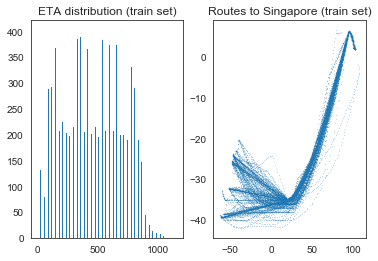

In [416]:
training_idx = []

for i in range(0, len(data.imo)):
    
    if (data.imo[i] in training):
        training_idx.append(i)
        
training_set = data.loc[training_idx,:]   


features = ['lon', 'eta'] #['lon', 'lat', 'eta']
training_data = training_set.loc[:, features]


y_train = training_data.loc[:, 'eta']
features.remove('eta')
training_data.drop('eta', axis=1, inplace=True)
X_train = training_data.loc[:, features]


visit = 0
for imo in training:
    t = sma[sma.imo == imo]
    
    visit += len(t[t.arrived == 1])
    

print("Number of visits: %d" %visit)
print(len(training_set.imo))

plt.subplot(122)
plt.title("Routes to Singapore (train set)")
plt.scatter(training_set.lon, training_set.lat, s=0.01)
plt.subplot(121)
plt.title("ETA distribution (train set)")
plt.hist(y_train, bins=100)

plt.savefig("EDA_TRAINING.png")
plt.show()

### Test set

Number of visits: 88
Length train set: 8066


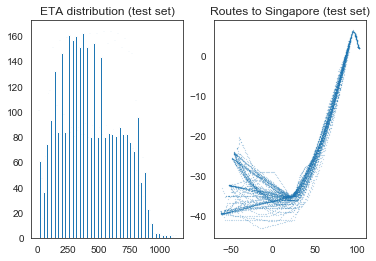

In [415]:

test_idx = []
for i in range(0, len(data.imo)):
    
    if (data.imo[i] in test):
        test_idx.append(i)

test_set = data.loc[test_idx,:]

features = ['lon', 'eta']  #['lon', 'lat', 'eta'] 

test_data = test_set.loc[:, features]

y_test = test_data.loc[:, 'eta']
features.remove('eta')
test_data.drop('eta', axis=1, inplace=True)
X_test = test_data.loc[:, features]

visit = 0
for imo in test:
    t = sma[sma.imo == imo]
    
    visit += len(t[t.arrived == 1])
    

print("Number of visits: %d" %visit)
print("Length train set: %d" %len(test_set))


plt.subplot(122)
plt.title("Routes to Singapore (test set)")
plt.scatter(test_set.lon, test_set.lat, s=0.01)
plt.subplot(121)
plt.title("ETA distribution (test set)")
plt.hist(y_test, bins=100)

plt.savefig("EDA_TEST.png")
plt.show()

### Metric

In [392]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

### BASELINE

In [393]:
baseline_guess = np.median(y_train)
baseline_guess

448.0

### MODEL

In [394]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

model = [LinearRegression(), SGDRegressor(), DecisionTreeRegressor()]

reg = make_pipeline(StandardScaler(), model[0])
reg.fit(X_train, y_train)


# predict / testing
pred = reg.predict(X_test)

#Result

baseline_guess = np.median(y_train)

residual_frame = pd.DataFrame({'true': y_test, 'pred': pred})

mae_base = round(mae(y_test, baseline_guess),2)
mae_model = round(mae(y_test, pred),2)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae_base)
print("Model Performance on the test set: MAE = %0.4f" % mae_model)
print("R2 score (train): %f" %reg.score(X_train, y_train))
print("R2 score (test): %f" %reg.score(X_test, y_test))


The baseline guess is a score of 448.00
Baseline Performance on the test set: MAE = 203.6500
Model Performance on the test set: MAE = 35.9200
R2 score (train): 0.956705
R2 score (test): 0.959683


In [395]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

model = [LinearRegression(), SGDRegressor(), DecisionTreeRegressor()]

reg = make_pipeline(StandardScaler(), model[1])
reg.fit(X_train, y_train)

reg.fit(X_train, y_train)


# predict / testing
pred = reg.predict(X_test)

#Result

baseline_guess = np.median(y_train)

residual_frame = pd.DataFrame({'true': y_test, 'pred': pred})

mae_base = round(mae(y_test, baseline_guess),2)
mae_model = round(mae(y_test, pred),2)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae_base)
print("Model Performance on the test set: MAE = %0.4f" % mae_model)
print("R2 score (train): %f" %reg.score(X_train, y_train))
print("R2 score: %f" %reg.score(X_test, y_test))


The baseline guess is a score of 448.00
Baseline Performance on the test set: MAE = 203.6500
Model Performance on the test set: MAE = 35.8900
R2 score (train): 0.956696
R2 score: 0.959746


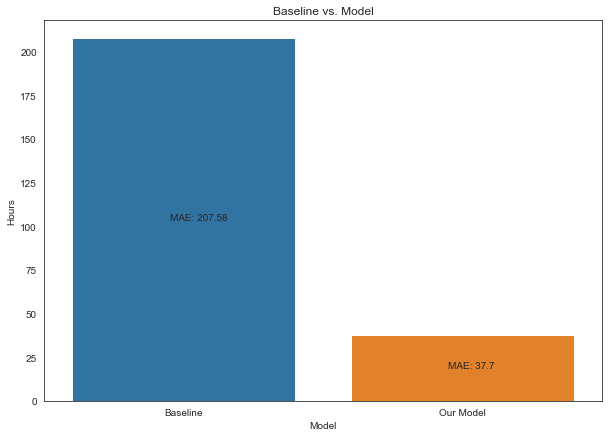

In [331]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 7))

x = ["Baseline", "Our Model"]
y = [mae_base, mae_model]
sns.barplot(x = x,y = y, ax = ax)#" legend = True)
plt.ylabel("Hours")
plt.xlabel("Model")
plt.title("Baseline vs. Model")
x_ = [0, 1]
for i, j in zip(x_, y):
    plt.annotate("MAE: {}".format(j), (i-0.05, j/2))


plt.savefig("BASELINE VS MODEL.png")

In [332]:
residual_frame['miss'] = residual_frame.true - residual_frame.pred
residual_frame.sort_values('true', ascending=False)





,true,pred,miss
12832,1152,810.253738,341.746262
24739,1072,918.646222,153.353778
14489,1071,873.695178,197.304822
14490,1064,866.727418,197.272582
24740,1064,912.717537,151.282463
...,...,...,...
6849,7,59.110507,-52.110507
26059,7,59.166847,-52.166847
15894,7,59.081553,-52.081553
26692,7,59.426374,-52.426374


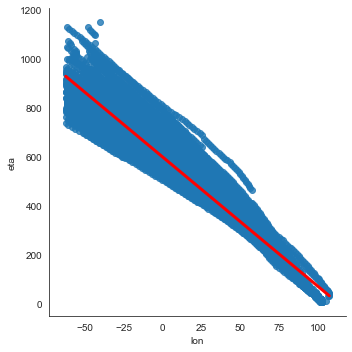

In [387]:

#sns.lmplot(x='lat', y='eta', data=data, line_kws={'lw': 3, 'color': 'r'})

sns.lmplot(x='lon', y='eta', data=data, line_kws={'lw': 3, 'color': 'r'})

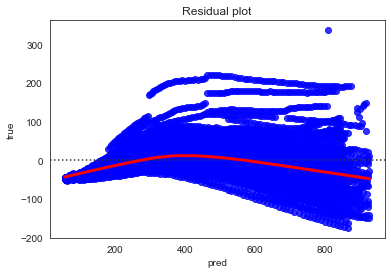

In [343]:
plt.title("Residual plot")

sns.residplot(x='pred', y='true', data=residual_frame, lowess=True, color="b", line_kws={'lw': 3, 'color': 'r'});

plt.savefig("residual_plot.png")

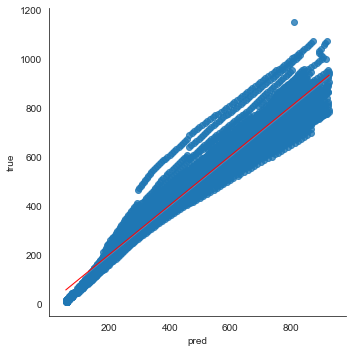

In [344]:
sns.lmplot(x='pred', y='true', data=residual_frame, line_kws={'lw': 1, 'color': 'r'})


(array([  15.,   30.,  191., 1006., 1099.,  269.,   55.,   67.,   60.,
          65.]),
 array([-163.61074625, -125.31298283,  -87.01521941,  -48.71745599,
         -10.41969257,   27.87807084,   66.17583426,  104.47359768,
         142.7713611 ,  181.06912452,  219.36688794]),
 <a list of 10 Patch objects>)

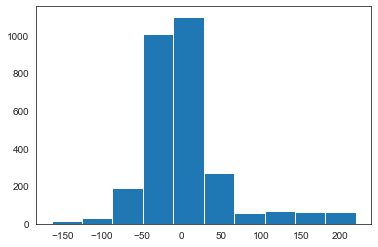

In [284]:
residual_frame['miss'] = residual_frame.true - residual_frame.pred

residual_frame.sort_values('true', ascending=False).head(30)


plt.hist(residual_frame.miss)